# Utilizando técnicas de balanceamento no modelo LightGBM

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Carregando os dados do Dataset e o transformando em um DataFrame

In [3]:
df = pd.read_csv('dataset_tratado.csv')

df['ZSN'].value_counts()


ZSN
0    1306
1     394
Name: count, dtype: int64

## Separando as classes, aplicando o algoritmo de balanceamento na classe minoritária e combinando o DataFrame

In [4]:
df_majority = df[df.ZSN==0]
df_minority = df[df.ZSN==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=1306, random_state=123)
 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.ZSN.value_counts()


ZSN
0    1306
1    1306
Name: count, dtype: int64

## Separando as características (X) e os rótulos (y)

In [5]:
X = df_upsampled.drop('ZSN', axis=1)
y = df_upsampled['ZSN']


## Dividindo os dados em conjuntos de treinamento e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Criando conjuntos de dados do modelo LightGBM

In [7]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


## Criando uma intância da classe LGBMClassifier para definir os parâmetros e em seguida treinando o modelo

In [8]:
model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_error',
    boosting_type='gbdt',
    num_leaves=35,
    learning_rate=0.05,
    feature_fraction=0.9
)

model.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 1053, number of negative: 1036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 2089, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504069 -> initscore=0.016276
[LightGBM] [Info] Start training from score 0.016276


LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, metric='binary_error',
               num_leaves=35, objective='binary')

## Verificando se o treinamento está sendo feito de forma correta, em seguida criando e plotando os gráficos de Treinamento e teste, Curva ROC e Matriz de Confusão, além de imprimir as métricas do modelo

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 1045, number of negative: 1044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 2089, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500239 -> initscore=0.000957
[Ligh

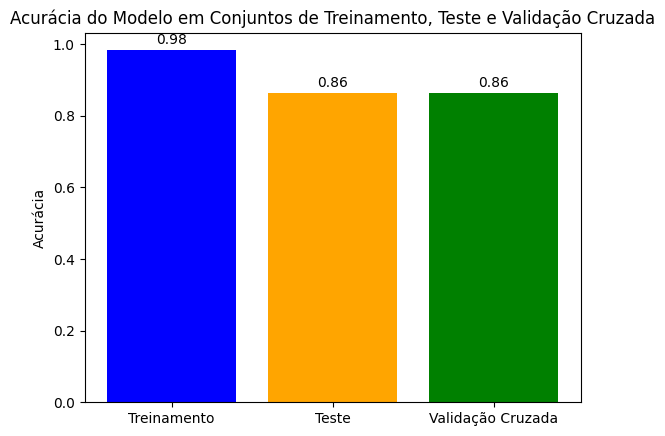

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


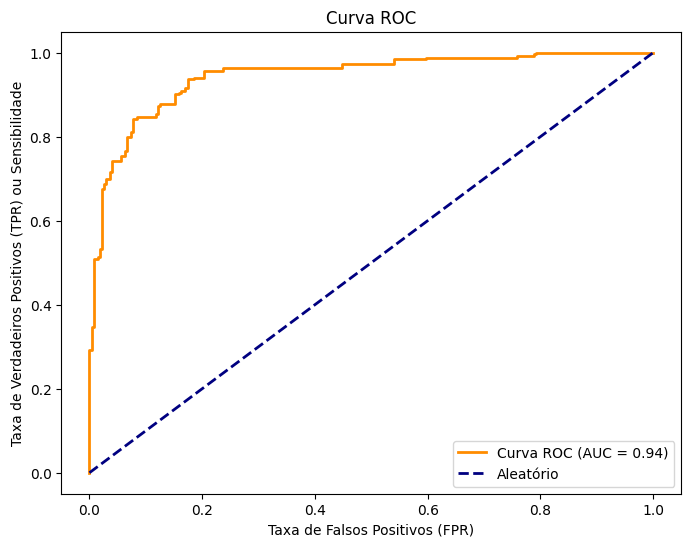

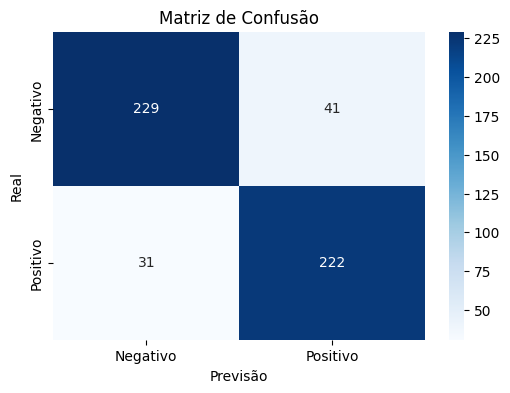

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       270
           1       0.84      0.88      0.86       253

    accuracy                           0.86       523
   macro avg       0.86      0.86      0.86       523
weighted avg       0.86      0.86      0.86       523



In [9]:
try:
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Converter as probabilidades para rótulos binários usando um limiar (0.5)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
    y_train_pred_binary = [1 if pred > 0.5 else 0 for pred in y_train_pred]
    
    # Avaliar o desempenho do modelo
    accuracy_test = accuracy_score(y_test, y_pred_binary)
    accuracy_train = accuracy_score(y_train, y_train_pred_binary)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    average_cv_accuracy = np.mean(cv_scores)
    accuracies = [accuracy_train, accuracy_test, np.mean(cv_scores)]

    #Criando e plotando gráfico de Treinamento e teste com Cross Validation
    labels = ['Treinamento', 'Teste', 'Validação Cruzada']
    for i in range(len(labels)):
        plt.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha='center', va='bottom')
        
    plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
    plt.ylabel('Acurácia')
    plt.title('Acurácia do Modelo em Conjuntos de Treinamento, Teste e Validação Cruzada')
    plt.show()

    #Crir e calcular a Curva ROC
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR) ou Sensibilidade')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular e plotar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

    # Imprimir relatório de classificação (métricas)
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred_binary, zero_division=0))
except Exception as e:
    print(f"Erro: {str(e)}")
    

In [10]:
probs_test = pd.DataFrame(model.predict_proba(X_test)[:, 1])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [11]:
probs_test.shape

(523, 1)

In [12]:
y_test.shape

(523,)

In [13]:
probs_test.index

RangeIndex(start=0, stop=523, step=1)

In [14]:
y_test.reset_index(drop=True)

0      0
1      0
2      0
3      1
4      1
      ..
518    0
519    1
520    0
521    1
522    0
Name: ZSN, Length: 523, dtype: int64

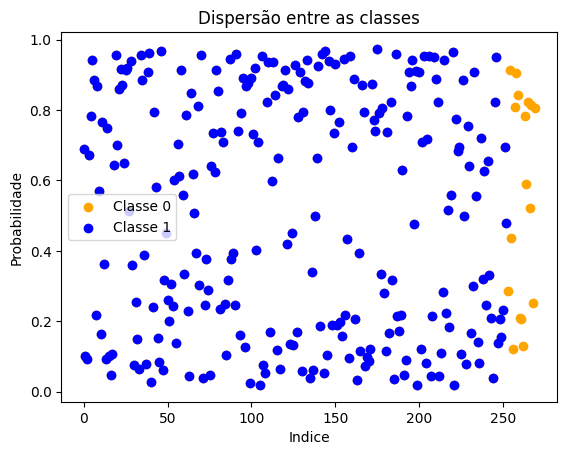

In [15]:
for label in [0, 1]:
    color = 'orange' if label == 0 else "blue"
    class_label = 'Classe 0' if label == 0 else 'Classe 1'
    df_label = y_test[y_test.isin([label])]
    df_probs = probs_test.iloc[df_label.reset_index(drop=True).index]
    
    plt.scatter(x=range(len(df_label)), y=df_probs, c=color, label=class_label)
plt.title('Dispersão entre as classes')
plt.xlabel('Índice')
plt.ylabel('Probabilidade')
plt.legend()
plt.show()